In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import linregress
import statsmodels.api as sm

In [22]:
!ls

IR-data.xlsx        README.md           Vasicek-model.ipynb ~$NEDL_Vasicek.xlsx


In [23]:
ir = pd.read_excel('IR-data.xlsx')
ir['delta'] = ir['Interest rate'].diff()
ir.loc[:, ['Interest rate', 'delta']] = ir.loc[:, ['Interest rate', 'delta']].multiply(0.01)
ir = ir.bfill()
ir

,Date,Interest rate,delta
0,2010-12-30,0.0420,-0.0007
1,2011-01-06,0.0413,-0.0007
2,2011-01-13,0.0408,-0.0005
3,2011-01-20,0.0405,-0.0003
4,2011-01-27,0.0409,0.0004
...,...,...,...
582,2022-02-24,0.0314,-0.0001
583,2022-03-03,0.0301,-0.0013
584,2022-03-10,0.0309,0.0008
585,2022-03-17,0.0339,0.0030


In [24]:
train = ir.loc[ir['Date'] < '2021-01-01', :]
test = ir.loc[ir['Date'] >= '2021-01-01', :]

x_train = sm.add_constant(train['Interest rate'])
y_train = train['delta']

x_test = sm.add_constant(test['Interest rate'])
y_test = test['delta']

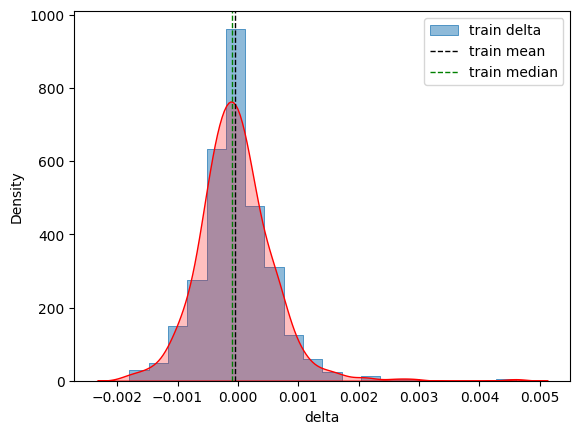

In [86]:
hist = sns.histplot(y_train, bins=20, alpha=0.5, label='train delta', stat='density', common_norm=False, element='step', fill=True, linewidth=0.5)
# add KDE
sns.kdeplot(y_train, color='red', linewidth=1, fill=True)

plt.axvline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label='train mean')
plt.axvline(y_train.median(), color='green', linestyle='dashed', linewidth=1, label='train median')

plt.legend()
plt.show()

In [26]:
linreg = sm.OLS(y_train, x_train).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.650
Date:                Thu, 22 Aug 2024   Prob (F-statistic):              0.104
Time:                        00:05:10   Log-Likelihood:                 3118.9
No. Observations:                 523   AIC:                            -6234.
Df Residuals:                     521   BIC:                            -6225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.000     -1.815      0.070      -0.001    2.95e-05
Interest rate     0.0099      0.006      1.628      0.104      -0.002       0.022
==============================================================================
Omnibus:                      167.563   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1219.777
Skew:                           1.199   Prob(JB):                    1.34e-265
Kurtosis:                      10.087   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
a_value = -1 * linreg.params[1]
b_value = linreg.params[0] / a_value
ir_t = x_train.loc[len(x_train)-1:, 'Interest rate'].values[0] # last value of interest rate on training set
linreg_mse = linreg.mse_resid # MSE for Residuals / Variance for the model
print(f' a: {a_value} \n b: {b_value} \n σ: {linreg_mse} \n last training data interest rate: {ir_t}')

 a: -0.009876313026699975 
 b: 0.036366347142708574 
 σ: 3.8845915744882564e-07 
 last training data interest rate: 0.0217


In [51]:
# forecasting with Vasicek model formula
vasicek_pred = []
for day in tqdm(range(len(test))):
    new_ir = ir_t * np.exp(a_value * day) + b_value * (1 - np.exp(a_value * day))
    new_var = (1 - np.exp(2 * a_value * day)) * linreg_mse / (2 * a_value)
    vasicek_pred.append([new_ir, new_var])

vasicek_pred_df = pd.DataFrame(vasicek_pred, columns=['Interest rate', 'Variance'])
vasicek_pred_df['Date'] = test['Date'].values
vasicek_pred_df = vasicek_pred_df[['Date', 'Interest rate', 'Variance']]
vasicek_pred_df

100%|██████████| 64/64 [00:00<00:00, 75382.04it/s]


,Date,Interest rate,Variance
0,2021-01-07,0.021700,-0.000000e+00
1,2021-01-14,0.021844,-3.846477e-07
2,2021-01-21,0.021987,-7.617722e-07
3,2021-01-28,0.022128,-1.131521e-06
4,2021-02-04,0.022268,-1.494037e-06
...,...,...,...
59,2022-02-24,0.028177,-1.353435e-05
60,2022-03-03,0.028257,-1.365428e-05
61,2022-03-10,0.028337,-1.377187e-05
62,2022-03-17,0.028416,-1.388716e-05


In [52]:
# long run forecast
ir_long = b_value
vol_long = linreg_mse / (2 * a_value)
print(f'Long run interest rate: {ir_long} \nLong run variance: {vol_long}')

Long run interest rate: 0.036366347142708574 
Long run variance: -1.9666203187295268e-05


In [44]:
# OLS Prediction / forecasting with linear regression model
pred = linreg.predict(x_test)
linreg_mse = np.mean((pred - y_test) ** 2)
pred, linreg_mse, linreg.rsquared

(523   -1.458371e-04
 524   -1.389236e-04
 525   -1.408989e-04
 526   -1.418865e-04
 527   -1.408989e-04
            ...     
 582   -4.904920e-05
 583   -6.188841e-05
 584   -5.398736e-05
 585   -2.435842e-05
 586   -6.552651e-07
 Length: 64, dtype: float64,
 7.556971819659139e-07,
 0.005061365600110612)

In [82]:
ir4ols = ir.loc[len(train) - 1:, ['Date', 'Interest rate']]
ir4ols['Interest rate'] = ir4ols['Interest rate'].shift(1)
ir4ols.loc[:, 'Interest rate'] = ir4ols.loc[:, 'Interest rate'] + pred.values[1]
ir4ols = ir4ols.dropna()
ir4ols

,Date,Interest rate
523,2021-01-07,0.021561
524,2021-01-14,0.021461
525,2021-01-21,0.022161
526,2021-01-28,0.021961
527,2021-02-04,0.021861
...,...,...
582,2022-02-24,0.031361
583,2022-03-03,0.031261
584,2022-03-10,0.029961
585,2022-03-17,0.030761
